In [82]:
import emcee

In [83]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from lightkurve import KeplerTargetPixelFile
import numpy as np
import matplotlib.pyplot as plt
import lightkurve.injection as inj
from lightkurve.lightcurve import SyntheticLightCurve

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Fitting a Supernova Signal

Let's download a TPF of a K2 galaxy and create the light curve.  We won't normalize it, because knowing the background flux is important in the fitting process.

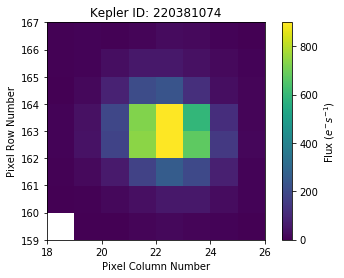

In [84]:
tpf = KeplerTargetPixelFile.from_archive(220381074) 
tpf.plot()

Text(0.5,1,'EPIC 220381074')

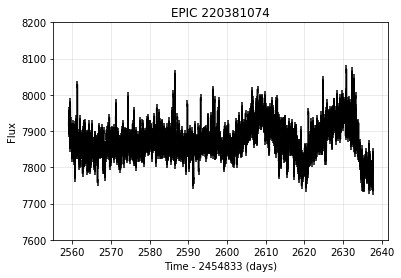

In [85]:
lc = tpf.to_lightcurve(aperture_mask='all')

#Remove nans and outliers
lc = lc.remove_nans().remove_outliers() 

lc.plot(normalize=False)
plt.ylim(7600, 8200)
plt.title('EPIC 220381074')

Now let's create a supernova model using `injection.SupernovaModel` class, and inject it using the `.inject` method.

This supernova will peak in the middle of the lightcurve, have a redshift of 0.5, and an amplitude of 2e-7 e/s/cm^2.

In [86]:
from lightkurve.injection import SupernovaModel

In [87]:
model = inj.SupernovaModel(T0=2600, source='hsiao', bandpass='kepler', z=0.5, amplitude=2.e-7)

In [88]:
lcinj = lc.inject(model)

Let's plot the model by itself (by evaluating it over the initial lightcurve's timestamps):

Text(0,0.5,'Flux')

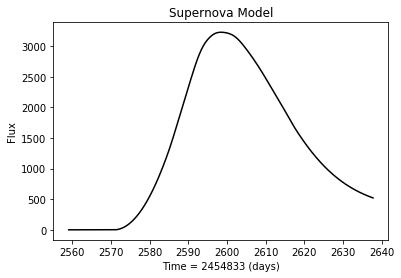

In [89]:
model_sn_eval = model.evaluate(lc.time)

plt.plot(lc.time, model_sn_eval, c='k')
plt.title('Supernova Model')
plt.xlabel('Time = 2454833 (days)')
plt.ylabel('Flux')

And now the model injected into our galaxy:

Text(0.5,1,'EPIC 220381074 With SN')

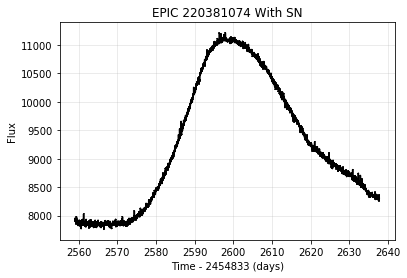

In [90]:
lcinj.plot(normalize=False)
plt.title('EPIC 220381074 With SN')

In [91]:
def ln_like(theta):
    T0, z, amplitude, background = theta
    if (z < 0) or (z > 3) or (T0 < np.min(lcinj.time)) or (T0 > np.max(lcinj.time)):
        return -np.inf
    model = SupernovaModel(T0, z=z, amplitude=amplitude, source='hsiao', bandpass='kepler')
    model_eval = model.evaluate(lcinj.time) + background
    inv_sigma2 = 1.0/(lcinj.flux_err**2)
    chisq = (np.sum((lcinj.flux-model_eval)**2*inv_sigma2))
    lnlikelihood = -0.5*chisq
    return lnlikelihood

In [92]:
ln_like([2600, 0.5, 2.e-7, 7800])

-128767.7229294619

In [93]:
fake_noise = np.random.normal(0, scale=lc.flux_err)

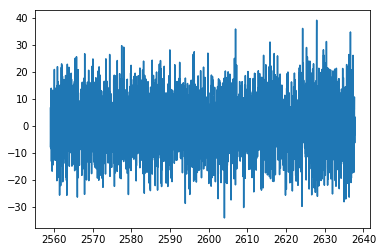

In [94]:
plt.plot(lcinj.time, fake_noise)

In [95]:
fake_background = 7800

In [96]:
fake_T0 = 2600

In [97]:
fake_z = 0.5

In [98]:
fake_amplitude = 2.e-8

In [99]:
model = inj.SupernovaModel(T0=fake_T0, source='hsiao', bandpass='kepler', z=fake_z, amplitude=fake_amplitude)
model_eval = model.evaluate(lcinj.time)

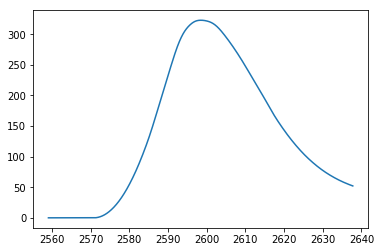

In [100]:
plt.plot(lcinj.time, model_eval)

In [101]:
fake_data = model_eval + fake_noise

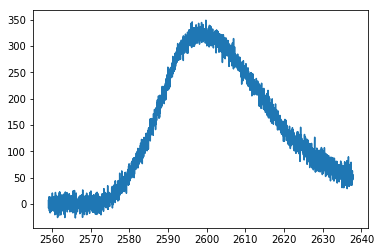

In [102]:
plt.plot(lcinj.time, fake_data)

In [103]:
ndim, nwalkers = 4, 40
pos = [[fake_T0, fake_z, fake_amplitude, fake_background] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [104]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_like, threads=2)

In [105]:
n_steps = 5000

In [ ]:
%%time
pos = sampler.run_mcmc(pos, n_steps)

/Users/gull/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


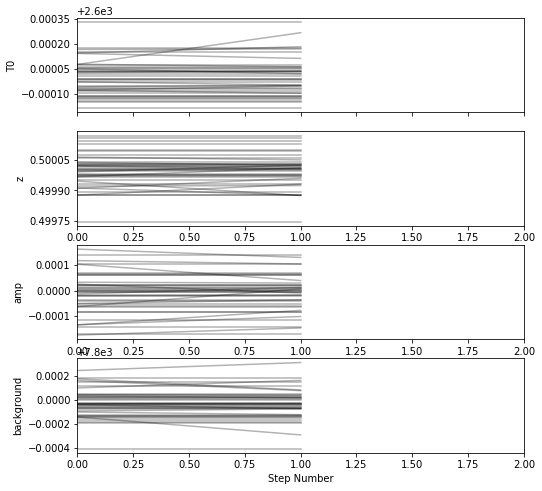

In [73]:
from matplotlib.ticker import MaxNLocator

samples = sampler.chain
labels = ['T0', 'z', 'amp', 'background']

fig1 = plt.figure(figsize=[8, 8])
for i in range(samples.shape[-1]):
    ax = fig1.add_subplot(4, 1, i + 1)
    ax.plot(sampler.chain[:, 0:1000, i].T, "k", alpha=0.3)
    ax.set_xlim(0, sampler.chain.shape[1])
    if i < 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("Step Number")
    ax.set_ylabel(labels[i])
    ax.yaxis.set_major_locator(MaxNLocator(4))

    plt.xlim(0, n_steps)
fig1.show()